# HSE 2024: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 10 days for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [50]:
from numpy import mean, absolute

In [51]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if y.size == 0:
        return 0
    
    return mean(absolute(y - mean(y)))

In [52]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

Берем столбец под индексом j их массива X, по порогу делим значения y на две части, после чего применяем данную формулу.

In [53]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    x = X[:, j]
    
    y_right = y[x > t]
    y_left = y[x <= t]

    Q = (y_left.size/y.size)*H(y_left) + (y_right.size/y.size)*H(y_right)
    
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

В методе best_split в цикле берем каждую фичу и каждое значение фичи, принимая ее за пороговое значение, передаем в функцию Q. Если cost меньше лучшего, записываем все значения и формируем сплит. Если с начального значения лучшее значение cost не изменилось, то возвращаем все значения None, сплит больше не улучшает cost.

В grow_tree сперва проверяем не терминальная ли нода, если нет, вызываем метод best_split. Если вернуло None, делаем ноду терминальной, задаем prediction и выходим. После задаем все параметры для ноды, высчитываем prediction и рекурсивно вызываем метод для дочерних узлов.

Метод get_prediction, наверное, описывать не нужно, сделано буквально то, что написано в docstring'е.

In [54]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    left : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [55]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    min_samples_leaf: int 
        Minimum number of samples (objects) in left and right branches after splitting the current node
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y)
        
        for column in range(X.shape[1]):
            x = X[:, column]

            for i_x in range(0, len(x)):
                threshold = x[i_x]

                cost = Q(X, y, column, threshold)
                if cost < best_cost:
                    best_split_column = column
                    best_threshold = threshold
                    best_cost = cost

                    X_left = X[x <= best_threshold]
                    y_left = y[x <= best_threshold]
                    X_right = X[x > best_threshold]
                    y_right = y[x > best_threshold]  

        if best_cost == H(y):
            return None, None, None, None, None, None
    
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y) or len(y) <= self.min_samples_leaf:
            node.is_terminal = True
            node.prediction = np.mean(y)
            return

        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if split_column is None or len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:
            node.is_terminal = True
            node.prediction = np.mean(y)
            return


        node.column = split_column
        node.threshold = threshold
        node.is_terminal = False

        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)
        
    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True

        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        
        if node.is_terminal == True:
            return node.prediction

        if x[node.column] > node.threshold:
            return self.get_prediction(node.right, x)
        else:
            return self.get_prediction(node.left, x)
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [56]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1 and 2** (root node has **depth 0**) and make the following plot for every case :

- Scatter plot of the traning points for each splitted feature (selected for split feature on the x-axis, target variable on the y-axis). Show the resulting thresholds

After that, fit analogical model from sklearn and visual it

Compare `MAE` on train and test. Have trees overfitted?

Дерево не переобучилось, значение MAE на тестовой выборке схоже со значением на тренировочной, на некоторых значениях random_state модель показывает себя лучше на тестовой. Обусловить это можно тем, что мы выставили небольшое значение max_depth и модель не успевает подстроится под тренировочные данные слишком сильно.

Вот что будет, если выставить max_depth=10:
- *Depth 10 - Train: 0.59, Test: 3.43*
- *SK Depth 10 - Train: 0.57, Test: 2.36*

Scatter plot сделать не смог.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

df = pd.read_csv('boston_house_prices.csv')

X = df.drop('TARGET', axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [58]:
model_depth_1 = MyDecisionTreeRegressor(max_depth=1)
model_depth_1.fit(X_train, y_train)

y_train_pred_1 = model_depth_1.predict(X_train)
y_test_pred_1 = model_depth_1.predict(X_test)

print(f'Depth 1 - Train: {mean_absolute_error(y_train, y_train_pred_1):.2f}, Test: {mean_absolute_error(y_test, y_test_pred_1):.2f}')

Depth 1 - Train: 6.89, Test: 6.22


In [59]:
model_depth_2 = MyDecisionTreeRegressor(max_depth=2)
model_depth_2.fit(X_train, y_train)

y_train_pred_2 = model_depth_2.predict(X_train)
y_test_pred_2 =model_depth_2.predict(X_test)

print(f'Depth 2 - Train: {mean_absolute_error(y_train, y_train_pred_2):.2f}, Test: {mean_absolute_error(y_test, y_test_pred_2):.2f}')

Depth 2 - Train: 5.05, Test: 4.84


In [60]:
from sklearn.tree import DecisionTreeRegressor

model_sk_1 = DecisionTreeRegressor(max_depth=1)
model_sk_1.fit(X_train, y_train)

y_train_sk_1 = model_sk_1.predict(X_train)
y_test_sk_1 =model_sk_1.predict(X_test)

print(f'SK Depth 1 - Train: {mean_absolute_error(y_train, y_train_sk_1):.2f}, Test: {mean_absolute_error(y_test, y_test_sk_1):.2f}')

SK Depth 1 - Train: 5.09, Test: 4.87


In [61]:
model_sk_2 = DecisionTreeRegressor(max_depth=2)
model_sk_2.fit(X_train, y_train)

y_train_sk_2 = model_sk_2.predict(X_train)
y_test_sk_2 =model_sk_2.predict(X_test)

print(f'SK Depth 2 - Train: {mean_absolute_error(y_train, y_train_sk_2):.2f}, Test: {mean_absolute_error(y_test, y_test_sk_2):.2f}')

SK Depth 2 - Train: 3.54, Test: 3.66


### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [1, 3, 5, 10, 20], 'min_samples_leaf': [1, 3, 5, 10, 20]}

tree = MyDecisionTreeRegressor()
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MyDecisionTreeRegressor(),
             param_grid={'max_depth': [1, 3, 5, 10, 20],
                         'min_samples_leaf': [1, 3, 5, 10, 20]},
             scoring='r2')

In [63]:
print(f'Params: {grid_search.best_params_}')

y_test_pred_gs = model_sk_1.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, y_test_pred_gs):.2f}')

Params: {'max_depth': 10, 'min_samples_leaf': 10}
Test MAE: 4.87


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [64]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    y = np.array(y)
    pred = np.zeros((n_iter, len(y)))
    
    for i in range(n_iter):
        bootstrap_indices = np.random.choice(len(x), size=len(x), replace=True)
        
        bootstrap_x = x[bootstrap_indices]
        bootstrap_y = y[bootstrap_indices]
        
        estimator.fit(bootstrap_x, bootstrap_y)
        pred[i, :] = estimator.predict(x)
    
    mean_pred = np.mean(pred, axis=0)

    bias2 = np.mean((mean_pred - y) ** 2)
    variance = np.mean(np.var(pred, axis=0))
    
    return bias2, variance

In [65]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train.values, y_train, 10)

(6.4878145711937965, 8.327945471506972)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

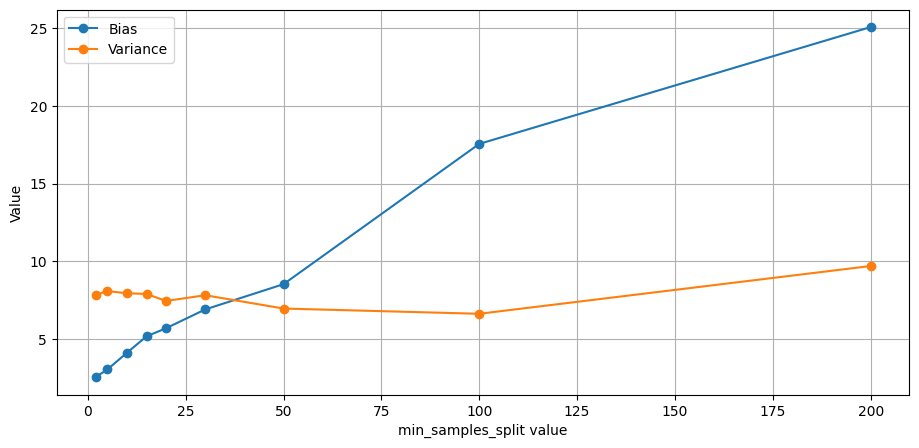

In [66]:
split_values = [2, 5, 10, 15, 20, 30, 50, 100, 200]

bias = []
variance = []

for split in split_values:
    estimator = DecisionTreeRegressor(min_samples_split=split, random_state=100)
    b, v = get_bias_variance(estimator , X_train.values, y_train, 10)
    bias.append(b)
    variance.append(v)

plt.plot(split_values, bias, label="Bias", marker='o')
plt.plot(split_values, variance, label="Variance", marker='o')
plt.xlabel("min_samples_split value")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

С увеличением значения min_samples_split bias увеличивается, что закономерно, ведь модель все более и более обобщенно подстраивается под модель, "не вдаваясь в детали". Почти на всех random_state variance мало изменяется при изменении min_samples_split, что отклоняется от теории, ведь чем больше min_samples_split, тем меньше модель подстраивается под конкретную выборку, значит разброс предсказаний модели должен быть меньше, но в этом случае этого мы не неблюдаем.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [67]:
from sklearn.ensemble import BaggingRegressor

estimator = MyDecisionTreeRegressor(max_depth=10, min_samples_split=10)
model_bagging = BaggingRegressor(estimator, 20)

b, v = get_bias_variance(model_bagging, X_train.values, y_train, 10)
print(f'Bias: {b}\nVariance: {v}')

Bias: 6.601905903992995
Variance: 3.7578331899351216


1. Бэггинг в первую очередь используется для снижения variance, он не дает модели переобучится, так как учитывает предсказания нескольких моделей, обученных на разных бутстрап-выборках.
2. Параметр variance падает соответственно количеству estimator'ов (чем больше n_estimators, тем ниже становится variance, но в какой-то момент, естественно, улучшение заканчивается, в данном случае variance остановился на значении около трех), bias остается практически таким же.
3. Да, результат эксперимента соотносится с теорией. 

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

In [68]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are more than 10 unique values in a column, use `min_frequency` and/or `max_categories` parameter)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

Droped columns (если больше 0.4 части всех значений пустые): `'organization', 'title', 'state', 'residenceStateRegion'`
Посмотрел numeric столбцы на корреляцию, максимальная была 0.78, но в целом почти все значения были до 0.5, так что решил не дропать.

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns

missing = X.isnull().mean()
to_drop = missing[missing > 0.4].index.tolist()
X = X.drop(columns=to_drop)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=['number']).columns

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', min_frequency=0.01)
)

numerical_transformer = SimpleImputer(strategy='mean')


column_transformer = ColumnTransformer([
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numerical_transformer, numerical_features)
])

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [70]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score

In [71]:


models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=5000)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    model.fit(X_train, y_train)

    train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    test_scores = []
    
    
    for _, val in cv.split(X_test, y_test):   
        y_pred = model.predict(X_test[val])
        
        score = f1_score(y_test[val], y_pred, average='macro')
        test_scores.append(score)
    
    print(model_name)
    print(f'Train: {np.mean(train_scores):.3f}')
    print(f'Test: {np.mean(test_scores):.3f}\n\n')

Gradient Boosting
Train: 0.852
Test: 0.745


Random Forest
Train: 0.851
Test: 0.764


Decision Tree
Train: 0.804
Test: 0.710


SVM
Train: 0.808
Test: 0.414


Logistic Regression
Train: 0.806
Test: 0.414




Лучше себя показали модели градиентного бустинга и рандомного леса. SVM и LogReg на тренировочной выборке показывают себя чуть лучше чем решающее дерево, но из значений f1 на тестовой выборке сразу становится понятно, что SVM и LogReg переобучились, f1 score в два раза меньше на тесте, чем на треине. 

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [72]:
from lightgbm import LGBMClassifier

param_grid = {
    'n_estimators': [10, 100, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [2, 3, 7, 10]
}


lgb_params = {"verbose": -1}
gbm_model = LGBMClassifier(**lgb_params, random_state=42)

grid_search = GridSearchCV(estimator=gbm_model, 
                           param_grid=param_grid,
                           scoring='f1'
                          )
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1:", grid_search.best_score_)

model = grid_search.best_estimator_

train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
test_scores = []

for _, val in cv.split(X_test, y_test):   
    y_pred = model.predict(X_test[val])
    
    score = f1_score(y_test[val], y_pred, average='macro')
    test_scores.append(score)

print(f'Train: {np.mean(train_scores):.3f}')
print(f'Test: {np.mean(test_scores):.3f}')

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best F1: 0.8596874259419186
Train: 0.857
Test: 0.725


Получаем небольшое улучшение на тренировочной выборке, но на тестовой LightGBM показывает себя немного хуже, чем градиентный бустинг и рандомный лес.

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [73]:
def fit_model(model, model_name):
    model.fit(X_train, y_train)

    train_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    test_scores = []
    
    for _, val in cv.split(X_test, y_test):   
        y_pred = model.predict(X_test[val])
        
        score = f1_score(y_test[val], y_pred, average='macro')
        test_scores.append(score)
    
    print(f'Train: {np.mean(train_scores):.3f}')
    print(f'Test: {np.mean(test_scores):.3f}')
        

In [74]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_tree = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
fit_model(bagging_tree, "Bagging with decision trees")

Train: 0.843
Test: 0.750


In [75]:
bagging_gradient_boosting = BaggingClassifier(estimator=GradientBoostingClassifier(), n_estimators=200, random_state=42)
fit_model(bagging_gradient_boosting, "Bagging with gradient boosting")

Train: 0.854
Test: 0.749


Остальные модели не получилось выполнить.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

F1-Score, Random Forest

Test: 0.753 
Train: 0.855